# Deep Learning Assignment 2

## Assignment 2: Transfer Learning,Convolutions, and Object Localisation in Keras



## PART 1 - Dataset Creation

- In this section, we are supposed to create a non-trivial binary image classification dataset. \

- We used a tool called [IDT](https://github.com/deliton/idt) to scrape images to create the dataset. \
- Our two classes for this Image classification problem are "malefaces" and "femalefaces" \
- Since the data was scrapped from Internet, we manually inspected the downloaded images to filter out only valid ones to feed the model with good data to learn. \
- Also since the images scrapped are of random shapes/sizes since they are downloaded from the internet, which can be later be reshaped to the required dimensions while feeding into the model. \
- [Here](https://nuigalwayie-my.sharepoint.com/:u:/g/personal/s_javvadi3_nuigalway_ie/EXhmWqWsn_pLvCzuh3xxe-0BH1Agqhu5WjRzuamJK9SqIA?e=Rwh1rf) is the link to dataset, just in-case if required for reference. It is a zip file which can be unzipped as shown below.

- References : \
 1) https://github.com/deliton/idt \
 2) https://www.tensorflow.org/tutorials/load_data/images \


In [ ]:
#importing the required libraries
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image_dataset_from_directory
import pathlib
import tensorflow as tf
import PIL
import PIL.Image
import matplotlib.image as img
from tensorflow.keras.preprocessing import image
import matplotlib.cm as cm
from IPython.display import Image, display  
import pandas as pd
import os
import cv2

In [ ]:
!unzip faces_dataset.zip

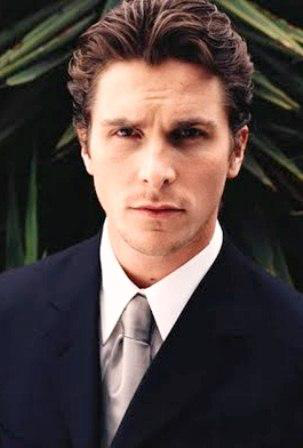

In [ ]:
# displaying sample images of the two classes used
# Reference : https://www.tensorflow.org/tutorials/load_data/images

data_dir = pathlib.Path('faces_dataset/dataset/train/')

# displaying a male face image
malefaces = list(data_dir.glob('maleface/*'))
PIL.Image.open(str(malefaces[0]))

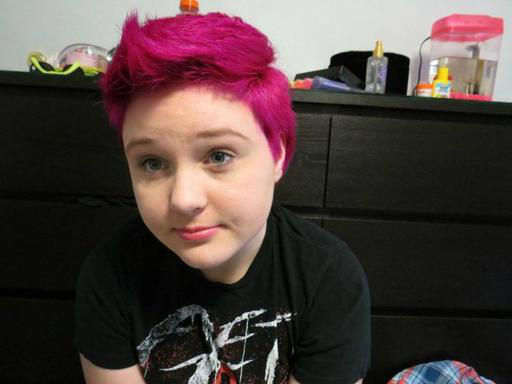

In [ ]:
#displaying a female face image
femalefaces = list(data_dir.glob('femaleface/*'))
PIL.Image.open(str(femalefaces[2]))

## PART 2 - Transfer Learning

- In this section we perform transfer learning to help us with the image classification task, as this saves a lot of training time and it's often observed that it improves performance of most of the neural networks without needing much data. \

- Transfer learning is basically the process of using models that have been trained on one problem as a starting point for solving a different problem. Using the representations/features learned by that previous network we can avoid training the model from scartch. Here we do not need to retrain the entire model,we can simply add few customs layers on top of the previously trained deep neural network, so that we will save a lot of training time and not always we have access to such huge computational power to train a model from scratch. Many top-performing ImageNet image recognition models, such as VGG, Inception, and ResNet, are accessible easily via Keras which can be used for transfer learning. \

- We would be using RESNET50 model for this problem just because of their sheer better performance on Image classification tasks due to the depth of the network. For several visual recognition tasks, the depth of representations is crucial, but it's more difficult to train deeper neural networks. Resnets present a residual learning system(skip connections) for training networks that are much deeper than previously used networks, which will help increase accuracy due to the considerably increased depth. When evaluated on the ImageNet dataset even though the residual nets had a depth of up to 152 layers---8x deeper than VGG nets , but still they had  lower complexity.

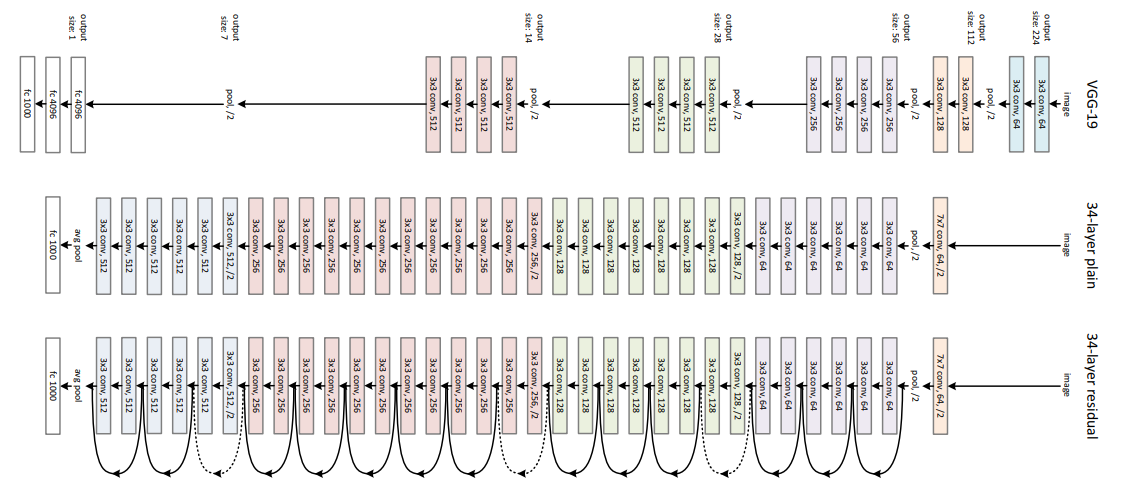

- The input shape to the ResNet50 model is (224,224,3) and the output is of the shape (7, 7, 2048) since we excluded the dense classification head. \

- In our model, after loading the resnet50 as the base model, we would be excluding the dense classification head of it and then add few custom layers and train them to produce classifications on the dataset. \
- GlobalAveragePooling2D() is the first custom layer we implemented, and it applies average pooling to the spatial dimensions until each one is one, thus leaving the other dimensions unchanged. In our case tensor (None, 7,7,2048) would be output as (None,2048). \

- Later, we added two more dense layers along with dropout ( which helps reduce overfitting) which can be seen below in the model.summary(). \


- References : \
1) https://keras.io/api/applications/resnet/#resnet50v2-function \
2) https://www.tensorflow.org/tutorials/images/transfer_learning \
3) https://www.tensorflow.org/tutorials/images/data_augmentation \
4) https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/ \
5) Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun.
Deep Residual Learning for Image Recognition. 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR) \

In [ ]:
#reshaping the image size according to requirement of input to the implemented model
IMAGE_SIZE = (224,224)

In [ ]:
# creating the training dataset
train_dataset = image_dataset_from_directory('faces_dataset/dataset/train',image_size=IMAGE_SIZE)

Found 742 files belonging to 2 classes.


In [ ]:
# creating the validation dataset
validation_dataset = image_dataset_from_directory('faces_dataset/dataset/validation',image_size=IMAGE_SIZE)

Found 144 files belonging to 2 classes.


In [ ]:
# creating the test dataset
test_dataset = image_dataset_from_directory('faces_dataset/dataset/test',image_size=IMAGE_SIZE)

Found 99 files belonging to 2 classes.


In [ ]:
#importing the required libraries
import os
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten,Dropout,GlobalAveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

In [ ]:
#performing data augmentation , since the dataset isn't huge and it also helps reduce overfitting
#Reference : https://www.tensorflow.org/tutorials/images/data_augmentation
data_augmentation = tf.keras.Sequential([
  RandomFlip('horizontal'),
  RandomRotation(0.25),
])

In [ ]:
# Creating the base model from the pre-trained ResNetv2 model
# by defining the include_top=False argument we are excluding the dense classification head(top) of the model
base_model = tf.keras.applications.ResNet50V2(include_top=False,weights='imagenet',input_shape=(224,224,3))

94674944/94668760 [==============================] - 1s 0us/step


In [ ]:
# freezing the base convolutional model, so that these weights aren't updated during training
for layer in base_model.layers:
	layer.trainable = False

In [ ]:
# A summary of all the layers that are present in the base model Resnet50
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [ ]:
#Reference : https://www.tensorflow.org/tutorials/images/transfer_learning

inputs = tf.keras.Input(shape=(224,224, 3)) #reshaping the inputs to (224,224,3) to input to the model
# Performing data augmentation of the inputs
x = data_augmentation(inputs) 
# Since the pixel values are in range [0-255], pre-processing them according to the requirment of the model
x = tf.keras.applications.resnet_v2.preprocess_input(x)
# adding the base model to our model
x = base_model(x, training=False)
#Applying the GlobalAveragePooling function here
x = GlobalAveragePooling2D()(x)
# adding a dense layer with 1024 neurons and relu activation to the model.
x = Dense(1024, activation='relu')(x) 
# adding dropout layer to avoid overfitting
x = Dropout(0.3)(x)
# adding a dense layer with 512 neurons and relu activation to the model.
x = Dense(512, activation='relu')(x)
# adding dropout layer similarly to avoid overfitting
x = Dropout(0.3)(x)
# finally applying a dense layer to convert the model output to a single prediction per image
# Since this prediction will be treated as a logit, we do not need an activation function here
outputs = Dense(1)(x)
#defining the model
model = tf.keras.Model(inputs, outputs)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
#compiling the model using the standard adam optimizer and binarycrossentropy loss,since our problem is a binary classification problem
model.compile(optimizer=Adam(lr=0.005),
              loss=BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
## A summary of all the layers that are present in the our model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              209817

In [ ]:
#training our model and saving it to a variable 'history'
history = model.fit(train_dataset,epochs=10,validation_data=validation_dataset)

Epoch 1/10
24/24 [==============================] - 97s 4s/step - loss: 6.2762 - accuracy: 0.6011 - val_loss: 0.2598 - val_accuracy: 0.8611
Epoch 2/10
24/24 [==============================] - 92s 4s/step - loss: 0.2847 - accuracy: 0.8867 - val_loss: 0.2038 - val_accuracy: 0.9375
Epoch 3/10
24/24 [==============================] - 93s 4s/step - loss: 0.2667 - accuracy: 0.8970 - val_loss: 0.3586 - val_accuracy: 0.9097
Epoch 4/10
24/24 [==============================] - 93s 4s/step - loss: 0.4792 - accuracy: 0.8298 - val_loss: 0.2091 - val_accuracy: 0.9236
Epoch 5/10
24/24 [==============================] - 93s 4s/step - loss: 0.2276 - accuracy: 0.9204 - val_loss: 0.2214 - val_accuracy: 0.8889
Epoch 6/10
24/24 [==============================] - 94s 4s/step - loss: 0.2238 - accuracy: 0.9119 - val_loss: 0.2000 - val_accuracy: 0.9306
Epoch 7/10
24/24 [==============================] - 94s 4s/step - loss: 0.1675 - accuracy: 0.9322 - val_loss: 0.1821 - val_accuracy: 0.9514
Epoch 8/10
24/24 [==

In [ ]:
# Reporting the classification accuracy and confusion matrix on unseen test dataset
# Reference : https://www.tensorflow.org/tutorials/images/transfer_learning
#             https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

import itertools
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

all_labels=[]  #list to hold all true labels of the images
all_predictions=[] #list to hold all the predicted labels of the images
for image_batch, labels_batch in test_dataset:
  #appending the true labels of the batch to all_labels list
  all_labels.append(labels_batch.numpy())
  #predicting the labels for each test_dataset batch and flattening the tensor
  preds = model.predict_on_batch(image_batch).flatten()
  # Applying a sigmoid since our model returns logits
  preds = tf.nn.sigmoid(preds)
  preds = tf.where(preds < 0.5, 0, 1)
  #appending the predicted labels of the batch to all_predictioons list
  all_predictions.append(preds.numpy())

#Converting list of lists to a single list of all_labels
all_labels = [list(itertools.chain(item)) for item in all_labels]
all_labels = list(itertools.chain.from_iterable(all_labels))

#Converting list of lists to a single list of all_predictions
all_predictions = [list(itertools.chain(item)) for item in all_predictions]
all_predictions = list(itertools.chain.from_iterable(all_predictions))

loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

#Confusion matrix using sklearn's confusion matrix for the test dataset
print('Confusion Matrix')
print(confusion_matrix(all_labels,all_predictions))

#Classification report on the test dataset
print('Classification Report')
target_names = ['femalefaces', 'malefaces']
print(classification_report(all_labels,all_predictions, target_names=target_names))


4/4 [==============================] - 10s 2s/step - loss: 0.1951 - accuracy: 0.9495
Test accuracy : 0.9494949579238892
Confusion Matrix
[[48  2]
 [ 3 46]]
Classification Report
              precision    recall  f1-score   support

 femalefaces       0.94      0.96      0.95        50
   malefaces       0.96      0.94      0.95        49

    accuracy                           0.95        99
   macro avg       0.95      0.95      0.95        99
weighted avg       0.95      0.95      0.95        99



We can observe that the model performs pretty well for the unseen images as well as it achieves ~94% accuracy on test dataset.




## PART 3 - Investigating the base model

- The goal here is to identify one or more neurons of the base model whose scalar output is strongly correlated with the class label of your dataset.

- To find out those neurons, we extract a scalar output from each neuron in the final layer of the base model using a GlobalMaxPooling2D layer and a softmax after that.

- Correlated neurons are selected by setting some threshold of correlation \
- Threshold is selected manually so we get more than a few correlated neurons \

- Since the model is untrained on the given dataset, the predictions are very unstable and gives different correlation to neurons each time we run the prediction.

- References: \
1) https://nbviewer.jupyter.org/github/fchollet/deep-learning-with-python-notebooks/blob/master/5.4-visualizing-what-convnets-learn.ipynb


In [ ]:
inputs = tf.keras.Input(shape=(224,224, 3)) #reshaping the inputs to (224,224,3) to input to the model
# Since the pixel values are in range [0-255], pre-processing them according to the requirment of the model
x = tf.keras.applications.resnet_v2.preprocess_input(inputs)
# base model
x = base_model(x, training=False)
# applying GlobalMaxPooling2D method to extract a scalar output from each neuron in the final layer of the base model
x = GlobalMaxPooling2D()(x)
# adding the softmax layer
outputs = Dense(2,activation="softmax")(x)
#defining the model
model1 = tf.keras.Model(inputs, outputs)

In [ ]:
from keras import models
import keras
# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model1.layers])
# get name of global max pooling layer
layer_name = list(layer_dict.keys())[-2]
 
#getting global max pooling layers output
layer_output = layer_dict[layer_name].output
# creating a model with model1s input and global max pooling layers output
activation_model =keras.Model(inputs=model1.inputs, outputs=layer_output)
activation_model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv_3 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_3 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 2048)              0         
Total params: 23,564,800
Trainable params: 0
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# get the scalar output from global max pooling layer
activations = activation_model.predict(validation_dataset)
# get softmax output from dense layer which contains two neurons as this is a binary classification task 
# 1st neuron output is assigned to activation2 variable 
activations2 = model1.predict(validation_dataset)[:,0]
# 2nd neurons output is assigned to activation3 variable 
activations3 = model1.predict(validation_dataset)[:,1]

# correlation for each neuron from globalMaxPooling layer is calculated with output neurons in dense layer
#corr0 holds correlations of class label 0
corr0=[]
# loop is iterated over all the neurons from globalmaxpooling layer
for i in range(np.shape(activations)[1]):
  #correlation is calculated using corrcoef from numpy library
  corr0.append(np.corrcoef(activations[:,i],activations2)[0,1])

#corr1 holds correlations of class label 1
corr1=[]
# loop is iterated over all the neurons from globalmaxpooling layer
for i in range(np.shape(activations)[1]):
  #correlation is calculated using corrcoef from numpy library
  corr1.append(np.corrcoef(activations[:,i],activations3)[0,1])

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [ ]:
# all the neurons that has correlation above the threshold are identified and stored in neurons1 list
neurons1=[]
#loop is run over all the correlations 
for i in range(0,len(corr1)-1):
  #neurons are filtered with a threshold
  if(corr1[i]>0.33):
    neurons1.append(i)
    # printing neurons that are correlated with class label 1
    print("neuron : "+ str(i) +" is strongly correlated to input image label 1 with correlation : "+str(corr1[i]))
neurons0=[]
#loop is run over all the correlations 
for i in range(0,len(corr0)-1):
  #neurons are filtered with a threshold
  if(corr0[i]>0.15):
    neurons0.append(i)
    # printing neurons that are correlated with class label 1
    print("neuron : "+ str(i) +" is strongly correlated to input image 0 label with correlation : "+str(corr0[i]))


neuron : 446 is strongly correlated to input image label 1 with correlation : 0.35428287926619795
neuron : 1166 is strongly correlated to input image label 1 with correlation : 0.3443707818569902
neuron : 593 is strongly correlated to input image 0 label with correlation : 0.17742706740147066
neuron : 783 is strongly correlated to input image 0 label with correlation : 0.16156285704713302
neuron : 869 is strongly correlated to input image 0 label with correlation : 0.1620488001677175
neuron : 1555 is strongly correlated to input image 0 label with correlation : 0.17287183912320878


## PART 4 - Visualising the 2D outputs

- 2d output from glabal max pooling layer is printed along with the heatmap of a new image. this is carried out on two images from two classes \

- We take all the neurons that are identified from part three and passed to superimposeHeatMap function which prints both 2d output of base layer andheatmap of the image. \

- Neurons that are correlated to class label 0 ( i.e female faces) are taken to produce heat map for female face images and neurons that are related to class 1 (i.e male faces) are taken to visualise class one images.

- Yes, the 2D outputs visualised allow localisation of objects in the input image for few of the images, as they were trained on other image classification objects. \

- References : \
1)https://keras.io/examples/vision/grad_cam/ \
2)https://www.pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/


In [ ]:
#model3 is created from base model input and output base model output
model3=keras.Model(inputs=base_model.inputs,outputs=base_model.outputs)
optimizer = tf.keras.optimizers.Adam(lr=0.0001)

#model3 is compiled to commit the changes made
model3.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:

# superimposing base models generated heatmap output with actual image
# References : https://keras.io/examples/vision/grad_cam/
# 			   https://www.pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/
def superimposed_heat_map(image_path,neuron,cam_path="cam.jpg"):
  img = keras.preprocessing.image.load_img(image_path, target_size=(224,224))
  x = keras.preprocessing.image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = tf.keras.applications.resnet_v2.preprocess_input(x)
  # considering only the output produced by specific neuron to generate heat map
  heatmap = model3.predict(x)[0,:,:,neuron] 
  #plotting the heatmap
  plt.matshow(heatmap, cmap='viridis')
  plt.show()
  
  #loading the original image
  img = keras.preprocessing.image.load_img(image_path)
  img = keras.preprocessing.image.img_to_array(img)

  # rescaling the heatmap to a range 0-255
  heatmap = np.uint8(255 * heatmap)   
  # Use jet colormap to colorize heatmap
  jet = cm.get_cmap("jet")                              

  # Use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  # Create an image with RGB colorized heatmap
  jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

  # Superimpose the heatmap on original image
  superimposed_image = jet_heatmap * 0.7 + img            
  superimposed_image = keras.preprocessing.image.array_to_img(superimposed_image)
  superimposed_image = superimposed_image.resize((300,300)) 
  # Save the superimposed image
  superimposed_image.save(cam_path)    
  # display gradcam
  display(Image(cam_path))

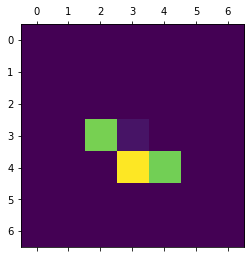

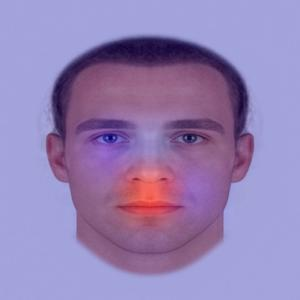

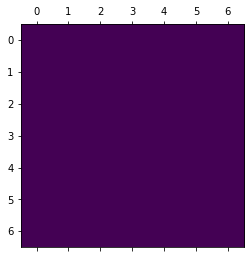

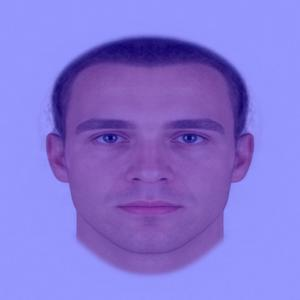

In [ ]:
#image is downloaded from given url
img_path=keras.utils.get_file("male2.jpg", "https://cdn.zmescience.com/wp-content/uploads/2018/05/169764_web.jpg")

#2d output for each strongly correlated neurons from base layer are produced and that 2d output is used to superimpose the image
for neuron in neurons1:
  superimposed_heat_map(img_path,neuron=neuron,cam_path="male2.jpg")

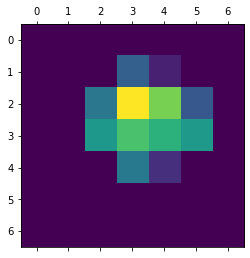

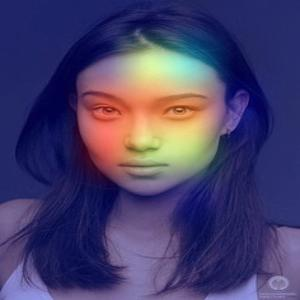

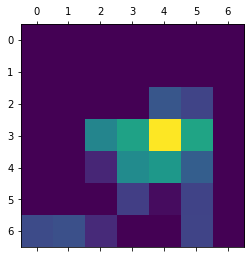

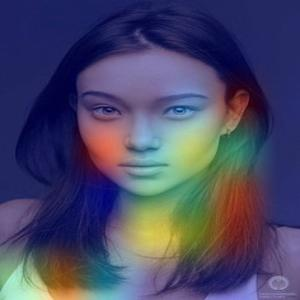

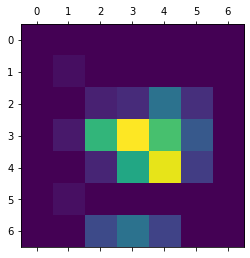

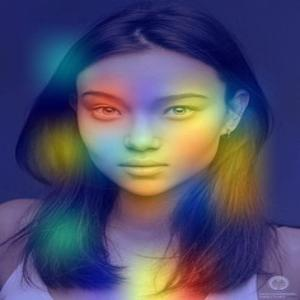

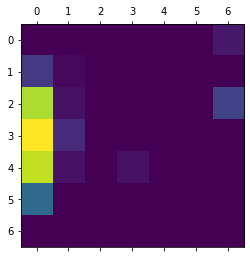

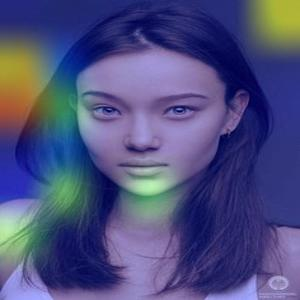

In [ ]:
#image is downloaded from given url
img_path=keras.utils.get_file("female01.jpg", "https://i.pinimg.com/236x/04/85/2a/04852a6784642fd85c91709f34fa73cc.jpg")
for neuron in neurons0:
  #2d output for each strongly correlated neurons from base layer are produced and that 2d output is used to superimpose the image
  superimposed_heat_map(img_path,neuron=neuron ,cam_path="female01.jpg")